In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install japanize-matplotlib

In [3]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [4]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [5]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.25.2
5.10.4
0.15.1


## データの準備など

In [6]:
# データ用意
parray1 = pd.read_csv(f"/content/gdrive/MyDrive/RとStanで学ぶベイズ統計/data/4-2-1-fish-num-3.csv")
df1 = pd.DataFrame(parray1)
print(df1.shape)
display(df1.head())

(100, 4)


,fish_num,weather,temperature,human
0,1,cloudy,6.0,A
1,7,cloudy,20.6,B
2,12,cloudy,27.5,C
3,0,cloudy,8.5,D
4,0,cloudy,3.1,E


## ランダム切片モデル

### 可視化

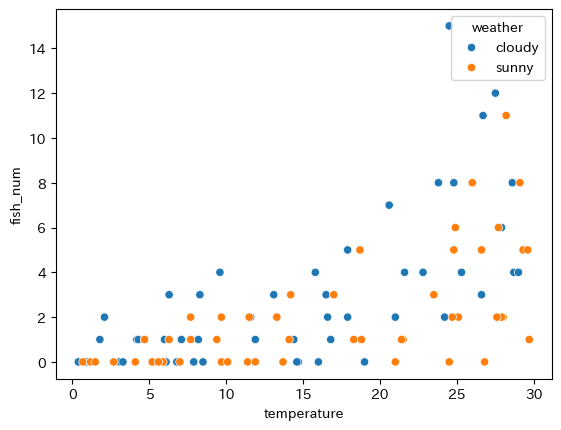

In [7]:
# データの可視化(天気ごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["weather"])

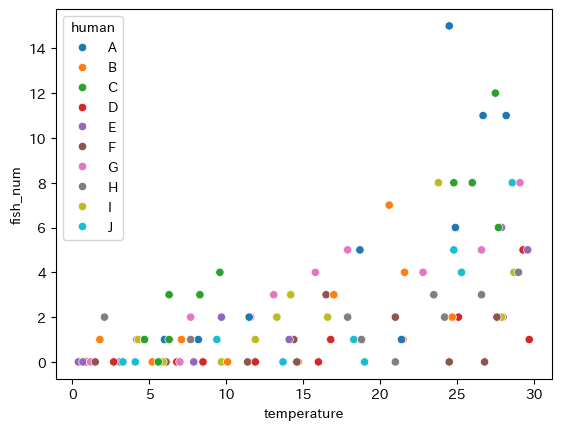

In [8]:
# データの可視化(humanごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["human"])

### ベイズ推論

In [9]:
# データの準備
y = parray1["fish_num"].values
weather = pd.get_dummies(df1["weather"], dtype=int, drop_first=True).values.reshape(-1)
temperature = df1["temperature"].values
cl = pd.Categorical(df1["human"]).codes

print(y[:5])
print(weather[:5])
print(temperature[:5])
print(df1["human"][:5])
print(cl[:5])

[ 1  7 12  0  0]
[0 0 0 0 0]
[ 6.  20.6 27.5  8.5  3.1]
0    A
1    B
2    C
3    D
4    E
Name: human, dtype: object
[0 1 2 3 4]


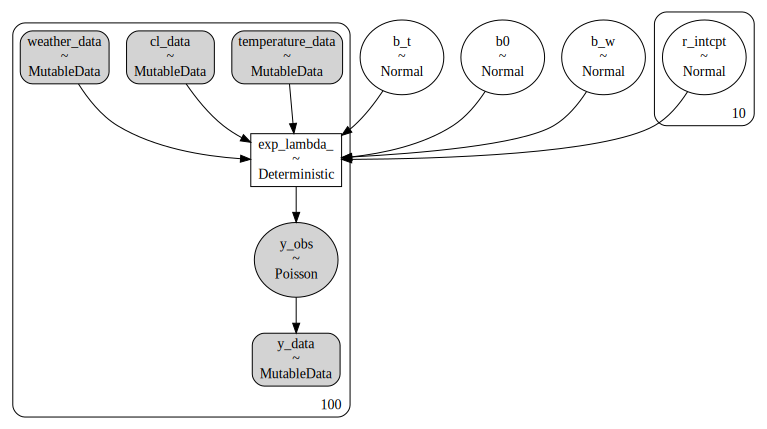

In [10]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    weather_data = pm.Data("weather_data", weather, mutable=True)
    temperature_data = pm.Data("temperature_data", temperature, mutable=True)

    # クラス変数を定義
    cl_data = pm.Data("cl_data", cl, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=10)
    b_w = pm.Normal("b_w", mu=0, sigma=10)
    b_t = pm.Normal("b_t", mu=0, sigma=10)

    # ランダム切片効果を定義
    r_intcpt = pm.Normal("r_intcpt", mu=0, sigma=10, shape=(10, ))

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_",
                                   pt.exp(b_w * weather_data + b_t * temperature_data + b0 + r_intcpt[cl_data]))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [11]:
# # 確率モデルの定義
# model = pm.Model()

# with model:
#     # 観測値をConstantDataとして定義
#     y_data = pm.Data("y_data", y, mutable=True)
#     weather_data = pm.Data("weather_data", weather, mutable=True)
#     temperature_data = pm.Data("temperature_data", temperature, mutable=True)

#     # クラス変数を定義
#     cl_data = pm.Data("cl_data", cl, mutable=True)

#     # パラメータを確率変数として定義
#     b0 = pm.Normal("b0", mu=0, sigma=10)
#     b_w = pm.Normal("b_w", mu=0, sigma=10)
#     b_t = pm.Normal("b_t", mu=0, sigma=10)

#     # ランダム切片効果を定義
#     r_intcpt_mu = pm.Normal("r_intcpt_mu", mu=0, sigma=10)
#     r_intcpt_sigma = pm.Normal("r_intcpt_sigma", mu=0, sigma=10)
#     r_intcpt = pm.Normal("r_intcpt", mu=r_intcpt_mu, sigma=r_intcpt_sigma, shape=(10, ))

#     # 目的変数の期待値を確率変数として定義
#     exp_lambda_ = pm.Deterministic("exp_lambda_",
#                                    pt.exp(b_w * weather_data + b_t * temperature_data + b0 + r_intcpt[cl_data]))

#     # 観測値を持つ確率変数として定義
#     y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

# g = pm.model_to_graphviz(model)
# display(g)

In [12]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 2000,
        draws = 1000,
        random_seed = 42,
        # target_accept = 0.99
    )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


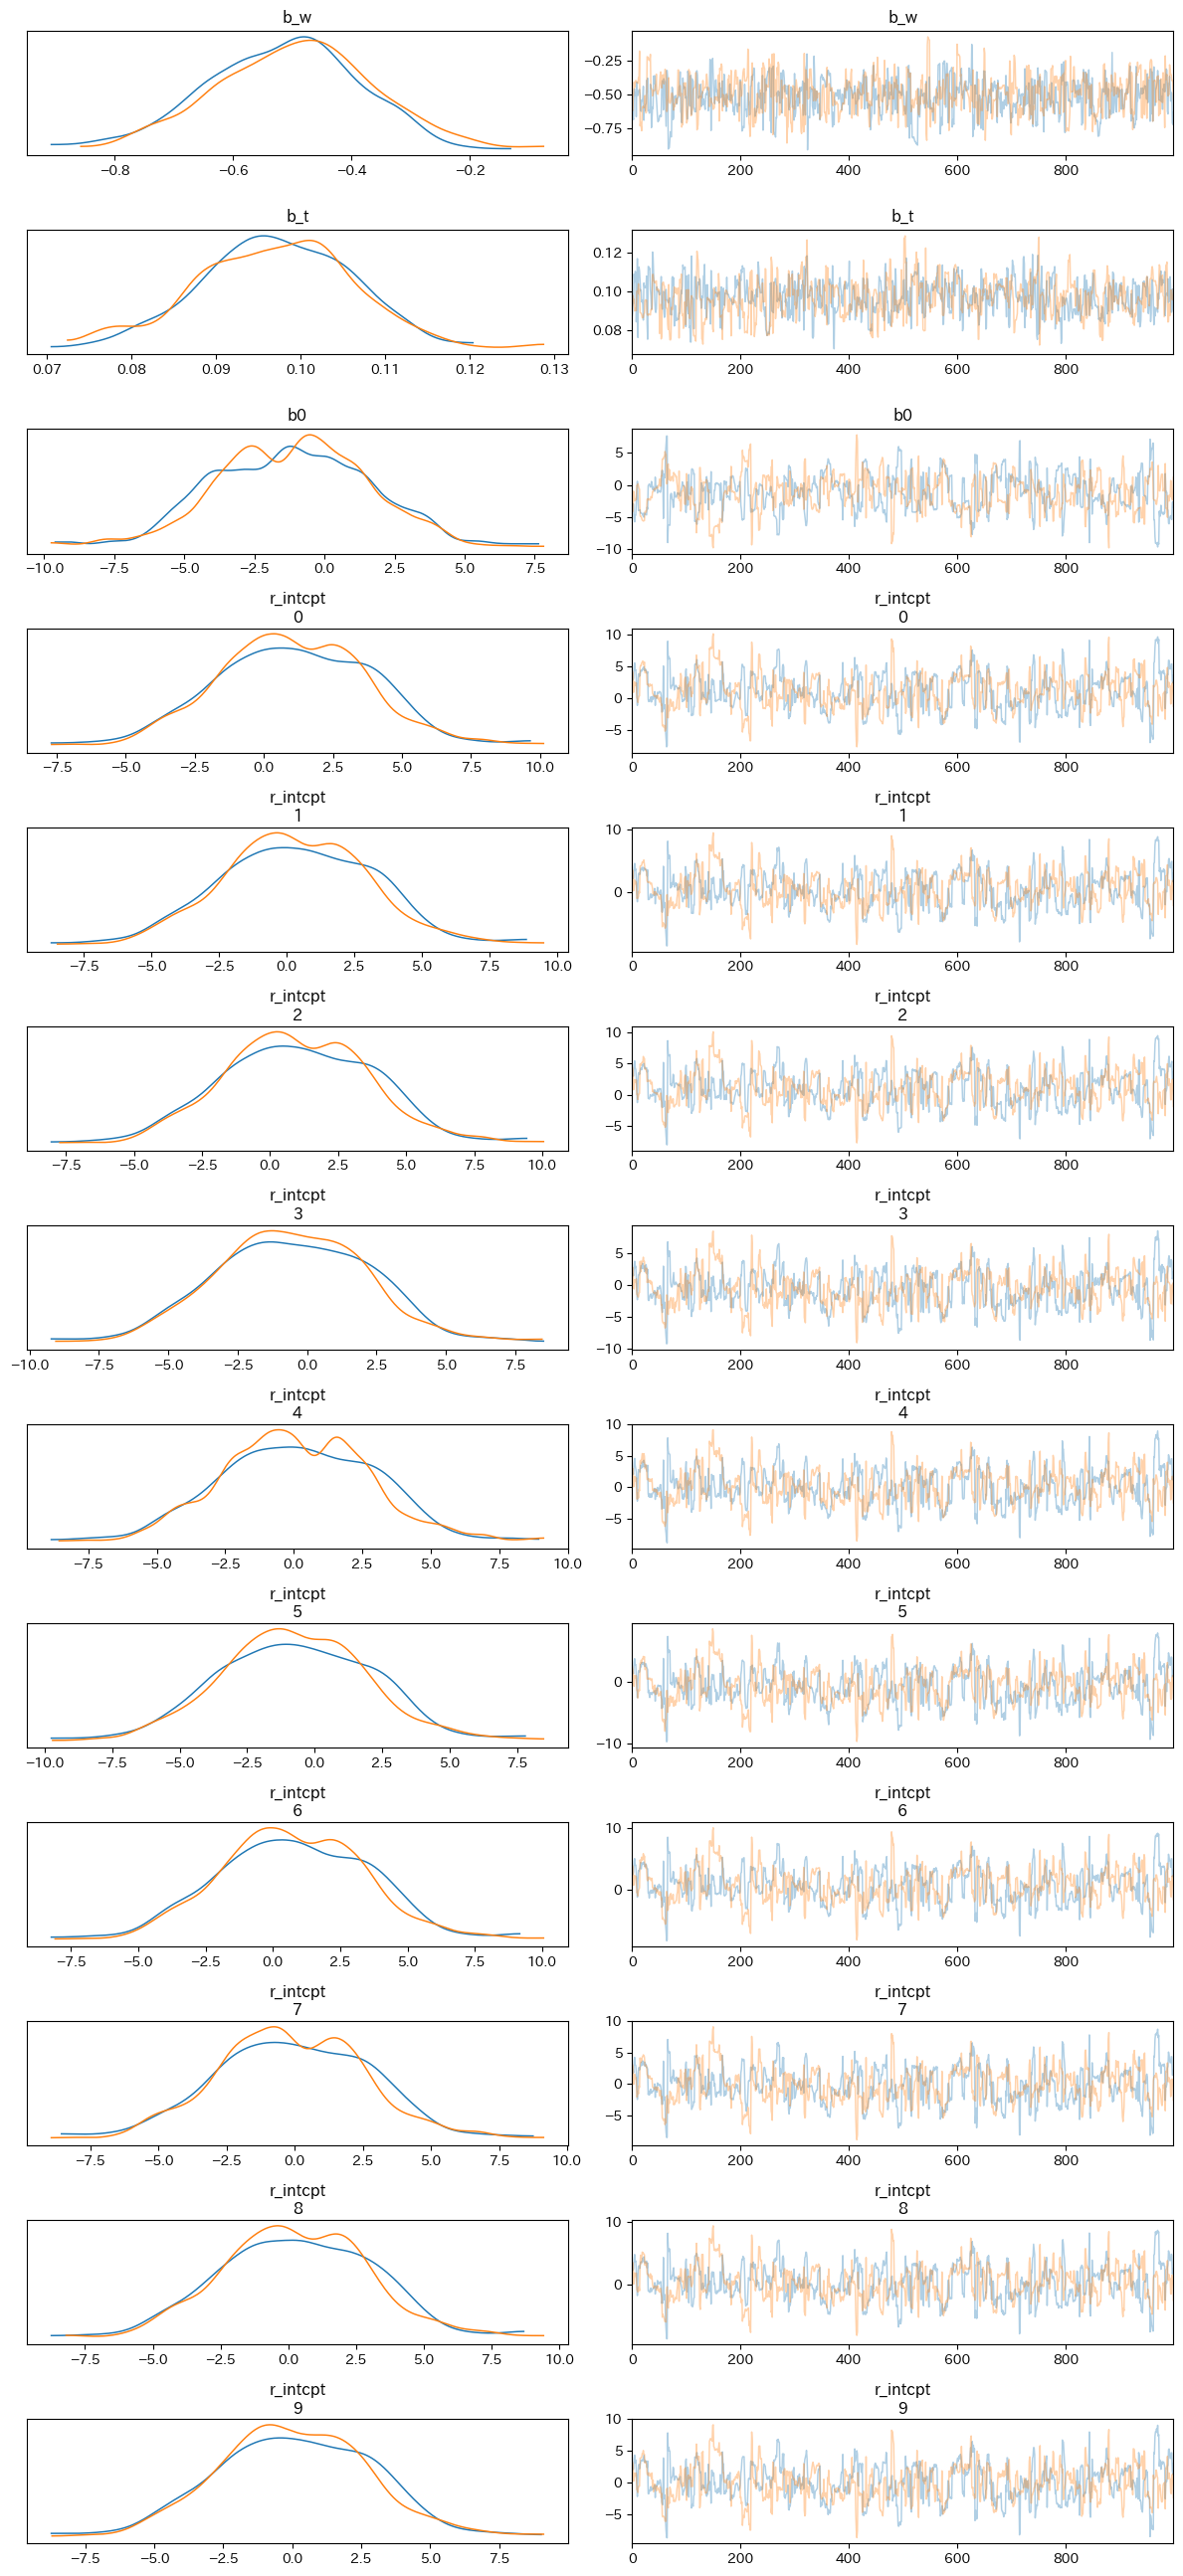

In [13]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0", "r_intcpt"])
# az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0"])
plt.tight_layout();

In [14]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b_w", "b_t", "b0", "r_intcpt"])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_w,-0.506,0.131,-0.747,-0.265,0.005,0.004,637.0,524.0,1.01
b_t,0.097,0.009,0.080,0.114,0.000,0.000,541.0,593.0,1.01
b0,-1.136,2.812,-6.022,4.102,0.178,0.126,247.0,352.0,1.01
r_intcpt[0],1.066,2.813,-4.212,5.954,0.179,0.127,245.0,307.0,1.01
r_intcpt[1],0.355,2.813,-4.938,5.326,0.177,0.125,251.0,329.0,1.01
r_intcpt[2],1.001,2.803,-4.271,5.896,0.178,0.126,246.0,326.0,1.01
r_intcpt[3],-0.553,2.809,-5.920,4.189,0.177,0.126,250.0,280.0,1.01
r_intcpt[4],0.124,2.823,-4.883,5.338,0.179,0.126,248.0,307.0,1.01
r_intcpt[5],-0.725,2.821,-6.289,4.138,0.178,0.126,251.0,325.0,1.01
r_intcpt[6],0.755,2.814,-4.350,5.851,0.179,0.127,246.0,315.0,1.01


In [15]:
# 描画したい範囲の温度データの配列作成
t_min = df1["temperature"].min()
t_max = df1["temperature"].max()
plot_num = 10
t_data =  np.linspace(t_min, t_max, plot_num)

# 各パラメータの抽出(今回は500個の回帰曲線)
bw_array = idata1.posterior["b_w"].values[0, :500].reshape(500, 1)
bt_array = idata1.posterior["b_t"].values[0, :500].reshape(500, 1)
b0_array = idata1.posterior["b0"].values[0, :500].reshape(500, 1)

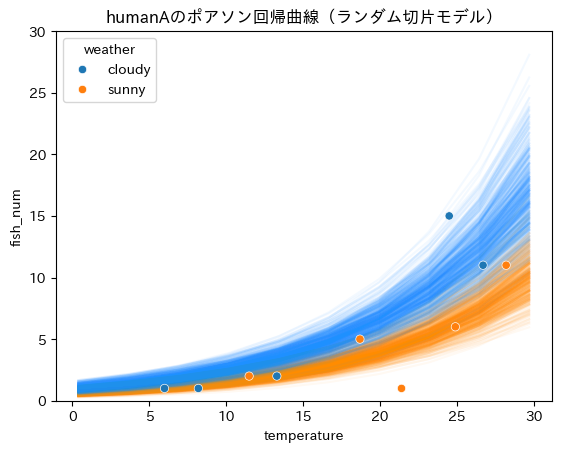

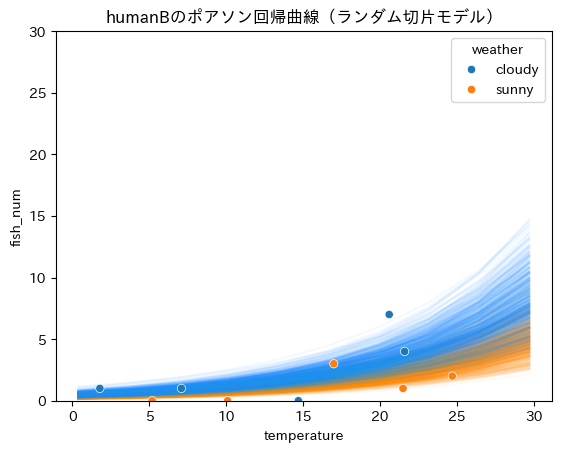

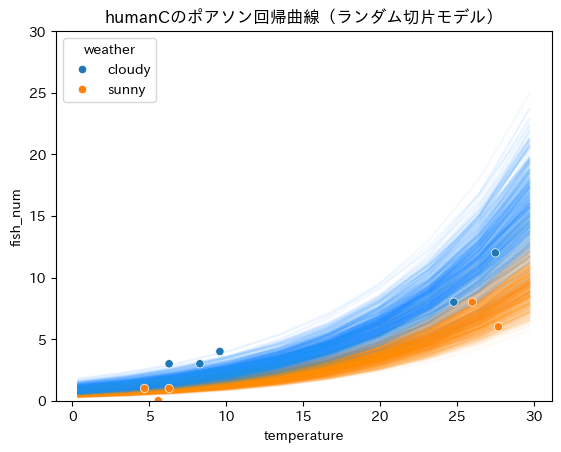

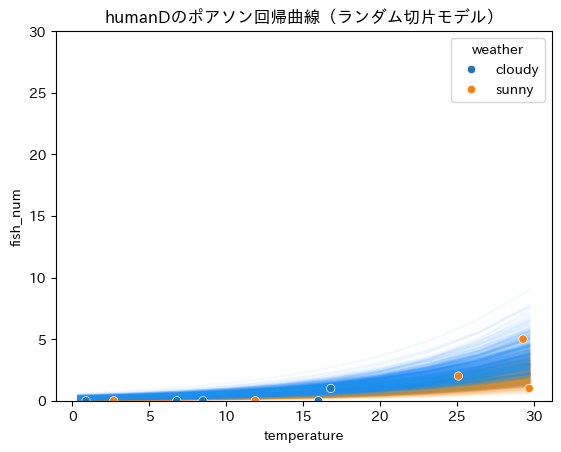

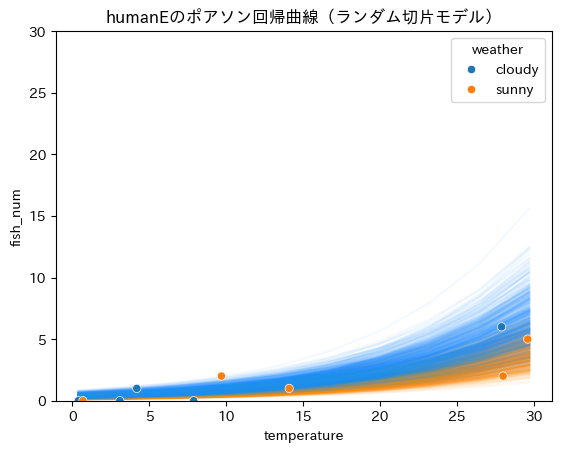

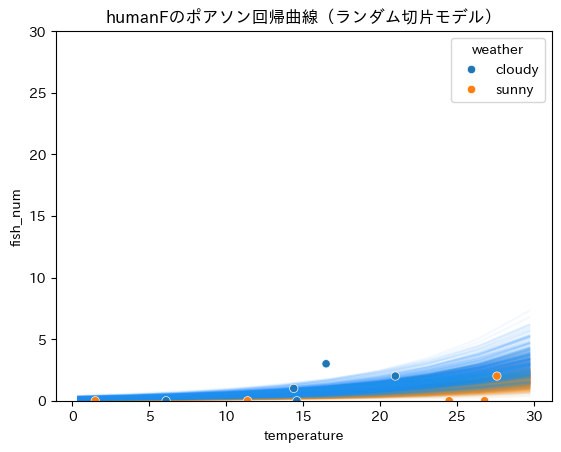

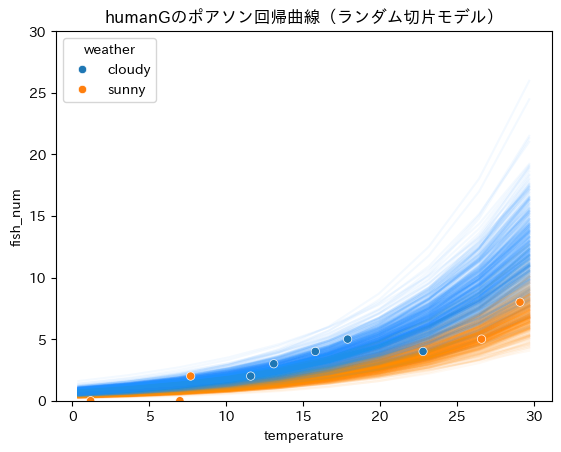

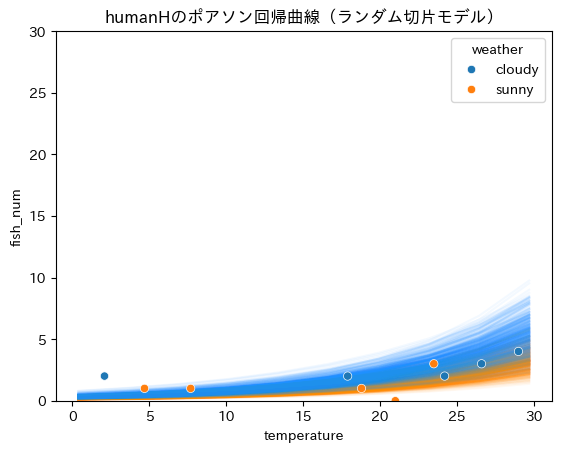

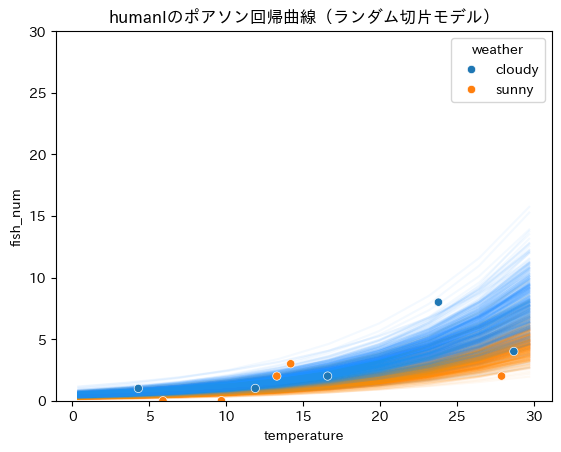

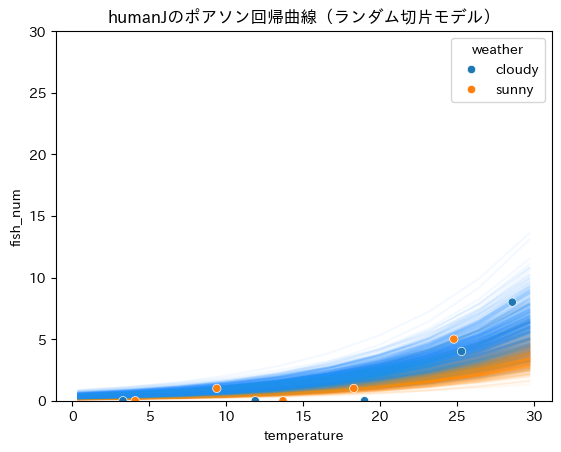

In [16]:
for i, name in enumerate(parray1["human"].unique().tolist()):
  # 各人のランダム効果（切片）
  r_intcpt_array = idata1.posterior["r_intcpt"][:, :, i].values[0, :500].reshape(500, 1)

  # 釣獲尾数の強度の計算
  lambda_sunny = bw_array + bt_array @ t_data.reshape(1, 10) + b0_array + r_intcpt_array
  lambda_cloudy = bt_array @ t_data.reshape(1, 10) + b0_array + r_intcpt_array

  # 釣獲尾数の期待値を計算
  e_sunny = np.exp(lambda_sunny)
  e_cloudy = np.exp(lambda_cloudy)

  # 描画
  fig, ax = plt.subplots()

  # 晴れの時のポアソン回帰曲線
  for y_pred in e_sunny:
      sns.lineplot(x=t_data, y=y_pred, color="darkorange", alpha=0.05, zorder=1)

  # 曇りの時のポアソン回帰曲線
  for y_pred in e_cloudy:
      sns.lineplot(x=t_data, y=y_pred, color="dodgerblue", alpha=0.05, zorder=1)

  # 観測データの散布図
  ax = sns.scatterplot(x = parray1[parray1["human"] == name]["temperature"],
                      y = parray1[parray1["human"] == name]["fish_num"],
                      hue = parray1[parray1["human"] ==name]["weather"],
                       zorder=2)
  ax.set(ylim=(0, 30))
  ax.set_title(f"human{name}のポアソン回帰曲線（ランダム切片モデル）")